In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Autoregressive Model</span>

In [2]:
msa_vmt = pd.read_csv('../../../results/historical_VMT_msa_basedon2022.csv',index_col=None) 
msa_vmt = msa_vmt.set_index('Year')
msa_vmt = msa_vmt[::-1]

In [3]:
#split the test and trainig set
split_index = round(len(msa_vmt)*0.8)
df_train = msa_vmt.iloc[:split_index].copy()
df_test = msa_vmt.iloc[split_index:].copy()

In [4]:
NHM_train = df_train['Bridgeport VMT (billion miles)']
NHM_test = df_test['Bridgeport VMT (billion miles)']

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">ARIMAX Model</span>

In [5]:
# Define the range of p, d, q parameters
p = d = q = range(0, 3)

# Generate all possible combinations of p, d, q parameters
pdq = list(itertools.product(p, d, q))

# Grid search for the optimal SARIMA parameters
best_aic = float("inf")
best_order = None
for params in pdq:
    try:
        mod = sm.tsa.SARIMAX(NHM_train, order=params, seasonal_order=(0, 0, 0, 0))
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = params
    except:
        continue

# Fit the SARIMA model with the optimal parameters
mod = sm.tsa.SARIMAX(NHM_train, order=best_order, seasonal_order=(0, 0, 0, 0))
res = mod.fit()

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978:

In [6]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(NHM_train)-1)
train_forecast_mean = train_forecast.predicted_mean
train_forecast_mean_re = train_forecast_mean
train_conf_int = train_forecast.conf_int()

new_index = [2012,2013,2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# Forecast on test data
test_forecast = res.get_prediction(start=len(NHM_train), end=len(NHM_train)+len(NHM_test)-1)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index

# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'New Haven VMT (billion miles)'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the actual values for the test set
actual_values = NHM_test
# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['New Haven VMT (billion miles)']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

In [8]:
# Forecast future emissions for the next 10 years
forecast_horizon = 10
forecast = res.forecast(steps=forecast_horizon)

# Calculate the confidence interval
forecast_object = res.get_forecast(steps=forecast_horizon)
confidence_interval = forecast_object.conf_int()

forecast.index = range(2023, 2033)

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


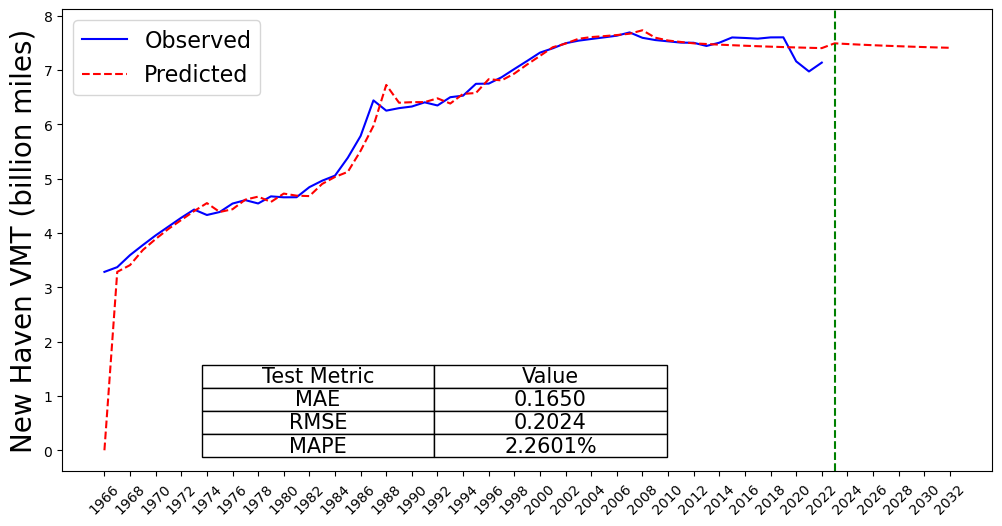

In [9]:
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([NHM_train,NHM_test])
#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['New Haven VMT (billion miles)'],forecast])
#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')
#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')
#combine the index
combined_index = np.concatenate([NHM_train.index, test_forecast_df.index,range(2023, 2033)])
plt.xticks(combined_index, rotation=45)
#plt.xlabel('Time', fontsize=16)
plt.ylabel('New Haven VMT (billion miles)', fontsize=20)
plt.legend(fontsize=16, loc='upper left')
# Set x-axis and y-axis tick labels with fontsize
tick_positions = combined_index[::2]
plt.xticks(tick_positions, rotation=45)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a vertical line at the x-axis for the year 2023
plt.axvline(x=2023, color='green', linestyle='--', label='Year 2023 (X-axis)')

#create a table to show the MAE and RMSE
# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.15, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed

plt.savefig('../../../figures/arima-population-vmt-Bridgeport-forecast.png', dpi=600, bbox_inches='tight')

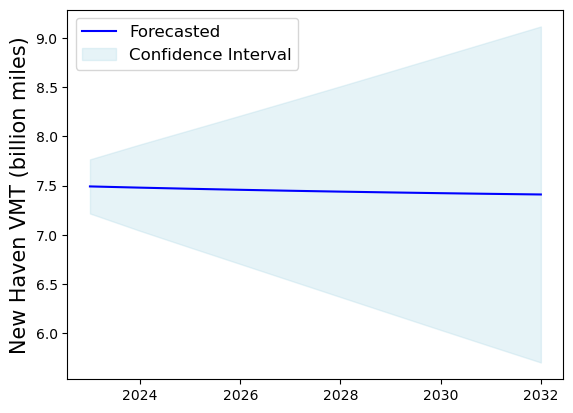

In [10]:
# Plot the forecasted values
plt.plot(forecast.index, forecast, color='blue', label='Forecasted')

# Plot the confidence interval
plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='lightblue', alpha=0.3, label='Confidence Interval')

plt.ylabel('New Haven VMT (billion miles)', fontsize=15)
plt.legend(fontsize=12, loc='upper left')

plt.savefig('../../../figures/Bridgeport-forecast-interval.png', dpi=600, bbox_inches='tight')

In [11]:
import string
df_vehicle_re = pd.read_csv('../../../data/raw/mv1.csv')

statewide_vehicle=df_vehicle_re.iloc[14,:]

#the total number of each vehicle type
statewide_automobile=statewide_vehicle[3]
statewide_buses=statewide_vehicle[6]
statewide_trucks=statewide_vehicle[9]
statewide_motorcycle=statewide_vehicle[12]
statewide_total=statewide_vehicle[15]

#ratio of each vehicle type to the total
statewide_automobile=int(statewide_automobile.translate(str.maketrans('','',string.punctuation)))
statewide_buses=int(statewide_buses.translate(str.maketrans('','',string.punctuation)))
statewide_trucks=int(statewide_trucks.translate(str.maketrans('','',string.punctuation)))
statewide_motorcycle=int(statewide_motorcycle.translate(str.maketrans('','',string.punctuation)))
statewide_total=int(statewide_total.translate(str.maketrans('','',string.punctuation)))

automobile_rat=statewide_automobile/statewide_total
buses_rat=statewide_buses/statewide_total
trucks_rat=statewide_trucks/statewide_total
motorcycle_rat=statewide_motorcycle/statewide_total

statewide_vehicle=statewide_vehicle.to_numpy()

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_14704\870287155.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  statewide_automobile=statewide_vehicle[3]
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_14704\870287155.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  statewide_buses=statewide_vehicle[6]
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_14704\870287155.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  statew

In [12]:
def emissions(VMT):
    automobile_vmt=VMT*automobile_rat
    buses_vmt=VMT*buses_rat
    trucks_vmt=VMT*trucks_rat
    motorcycle_vmt=VMT*motorcycle_rat

    #average MPG for each vehicle type ( miles per gallons)
    passenger_car_gasoline=24.1#automobile
    passenger_car_diesel=32.4
    light_truck_gasoline=18.5
    light_truck_diesel=22.1#trucks
    heavy_duty_gasoline=10.13
    heavy_duty_diesel=12.96#buses
    motorcycle_gasoline=50#motorcycle

    #emission factor for different fuels (kg CO2/gallon)( referenced from the ghg tool community module)
    gasoline=8.78
    diesel=10.21

    #calculate the fuel consumption in NH MSA
    gaso_consump= automobile_vmt/passenger_car_gasoline+motorcycle_vmt/motorcycle_gasoline
    dies_consump= buses_vmt/heavy_duty_diesel+trucks_vmt/light_truck_diesel

    #calcualte the gasoline and diesel emissions: carbon dioxide emissions only
    gaso_emissions =gaso_consump*gasoline/1000
    dies_emissions =dies_consump*diesel/1000

    #calculate the carbon dioxide consumption(metric tons):
    CO2=gaso_consump*gasoline/1000+dies_consump*diesel/1000

    gaso_auto=automobile_vmt/passenger_car_gasoline
    gaso_motor=motorcycle_vmt/motorcycle_gasoline
    die_trucks=trucks_vmt/light_truck_diesel
    die_buses=buses_vmt/heavy_duty_diesel

    #emission factor for different vehicles : g/miles ( referenced from EPA emission hub)
    # based on year 2005
    CH4_gaso_passenger_car=0.008
    N2O_gaso_passenger_car=0.007

    CH4_gaso_motorcycle=0
    N2O_gaso_motorcycle=0

    CH4_buses=0.005
    N2O_buses=0.005 #( meidum- heavy-duty vehicles in year 2005)

    CH4_trucks=0.001 #( light-duty trucks)
    N2O_trucks=0.001

    #calculate the CH4 emission (metric tons):
    CH4=automobile_vmt*CH4_gaso_passenger_car/1000000+motorcycle_vmt*CH4_gaso_motorcycle/1000000+buses_vmt*CH4_buses/1000000+trucks_vmt*CH4_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_1=CH4*25

    #calculate the N2O emission (metric tons):
    N2O = automobile_vmt*N2O_gaso_passenger_car/1000000 + motorcycle_vmt*N2O_gaso_motorcycle/1000000+buses_vmt*N2O_buses/1000000+trucks_vmt*N2O_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_2=N2O*298#define the number 

    #calculation of emissions from each types of vehicle,MMTCO2e(autombile, motorcycle, trucks, buses-NH,HH,BSN)
    automobile = (automobile_vmt/passenger_car_gasoline*gasoline/1000+automobile_vmt*CH4_gaso_passenger_car/1000000*25+automobile_vmt*N2O_gaso_passenger_car/1000000*298)*1000
    motorcycle = (motorcycle_vmt/motorcycle_gasoline*gasoline/1000+motorcycle_vmt*CH4_gaso_motorcycle/1000000*25+motorcycle_vmt*N2O_gaso_motorcycle/1000000*298)*1000
    buses = (buses_vmt/heavy_duty_diesel*diesel/1000+buses_vmt*CH4_buses/1000000*25+buses_vmt*N2O_buses/1000000*298)*1000
    trucks = (trucks_vmt/light_truck_diesel*diesel/1000+trucks_vmt*CH4_trucks/1000000*25+trucks_vmt*N2O_trucks/1000000*298)*1000

    total = automobile+motorcycle+buses+trucks
    
    return total

In [13]:
observed = emissions(concatenated_observed)
predicted = emissions(concatenated_predicted)
forecasted = emissions(forecast)
confidence_interval_emissions = emissions(confidence_interval)

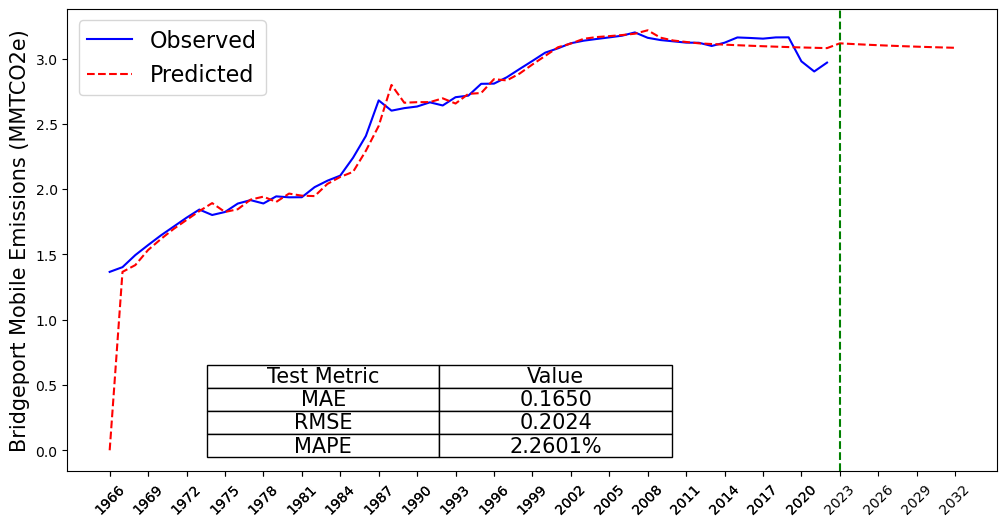

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(observed.index, observed, label='Observed', color='blue')
#plot the predicted value
plt.plot(predicted.index, predicted, label='Predicted', color='red', linestyle='--')
#combine the index
combined_index = np.concatenate([observed.index, predicted.index])
plt.xticks(combined_index, rotation=45)
#plt.xlabel('Time', fontsize=16)
plt.ylabel('Bridgeport Mobile Emissions (MMTCO2e)', fontsize=15)
plt.legend(fontsize=16, loc='upper left')
# Set x-axis and y-axis tick labels with fontsize
tick_positions = combined_index[::3]
plt.xticks(tick_positions, rotation=45)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a vertical line at the x-axis for the year 2023
plt.axvline(x=2023, color='green', linestyle='--', label='Year 2023 (X-axis)')

#create a table to show the MAE and RMSE
# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.15, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed

plt.savefig('../../../figures/arima-population-emissions-Bridgeport-forecast.png', dpi=600, bbox_inches='tight')

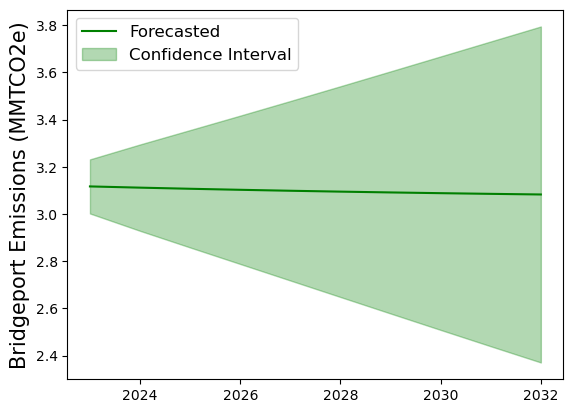

In [16]:
# Plot the forecasted values
plt.plot(forecasted.index, forecasted, color='green', label='Forecasted')

# Plot the confidence interval
plt.fill_between(forecasted.index, confidence_interval_emissions.iloc[:, 0], confidence_interval_emissions.iloc[:, 1], color='green', alpha=0.3, label='Confidence Interval')

plt.ylabel('Bridgeport Emissions (MMTCO2e)', fontsize=15)
plt.legend(fontsize=12, loc='upper left')

plt.savefig('../../../figures/Bridgeport-forecast-mobile-emissions-interval.png', dpi=600, bbox_inches='tight')